# Generative models with MNIST
## Using pytorch

## 4.CVAE

In [1]:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
# from __future__ import print_function
# import argparse
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import imageio
import matplotlib.pyplot as plt


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

proj_dir = './images/CVAE/' # 마지막 / 꼭 붙이기
if not os.path.exists('./images'):
    os.mkdir('./images')
if not os.path.exists(proj_dir):
    os.mkdir(proj_dir)

    
# Training settings
batch_size = 64 # one by one

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                              )
#                                download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

class CVAE(nn.Module):

    def __init__(self, proj_dir):
        super(CVAE, self).__init__()
        self.dim_mu = 6
        self.dim_sigma = self.dim_mu
        self.res_path = proj_dir
#         self.alpha = torch.tensor([1.], requires_grad=True).to(device)
#         self.beta = torch.tensor([1.], requires_grad=True).to(device)
#         self.gamma = torch.tensor([1.], requires_grad=True).to(device)
        self.alpha = torch.nn.Parameter(torch.scalar_tensor(4., requires_grad=True))
        self.beta = torch.nn.Parameter(torch.scalar_tensor(1., requires_grad=True))
        self.gamma = torch.nn.Parameter(torch.scalar_tensor(1., requires_grad=True))
        self.encoder = nn.Sequential(
#             nn.Linear(784+1, 512),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, self.dim_mu*2),
#             nn.BatchNorm1d(4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.dim_mu+1, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784*1),
        )

    def forward(self, x, target):
        # for label condition
        target = target.view(-1,1).float()
#         x_c = torch.cat((x, target), 1)
        x_c = x
        
        z = self.encoder(x_c)
        # Reparameterization trick
        self.mu = z[:, :self.dim_mu]
        self.logvar = z[:, self.dim_mu:]
        
        # multi normal  만들어야함...
        sample = nn.init.normal_(torch.empty(self.mu.shape), mean=0, std=1).to(device)
        z = sample.mul(self.logvar.exp()).add(self.mu)
        self.z_c = torch.cat((z, target), 1)
        
        y = self.decoder(self.z_c)
#         y = torch.sigmoid(y) # bernulli decoder는 시그모이드!! 소프트맥스 아님!!
        return y
    
    def loss(self, x, output, beta=1):
        # Reconstruction loss
#         self.recon_loss = F.binary_cross_entropy(output, x.view(-1, 784), reduction='mean')
        recon_criterion = nn.MSELoss(reduction='sum') # gaussian decoder w/ unit variance
        self.recon_loss = recon_criterion(x.view(-1, 784), output.view(-1, 784))

#         mu_ = output[:, :784]
#         self.logvar_ = output[:, 784:]
#         self.recon_loss = (self.logvar_ + (x-mu_).pow(2).div(self.logvar_.exp())).mul(0.5).sum() # gaussian decoder
        
        # KL 값이 적으면 z가 충분히 entangle되지 않음... 즉 condition의 정보가 z에 남음 
        self.KL_div = (self.mu.pow(2)+self.logvar.exp()-self.logvar-1).mul(0.5).sum()
        
        # condition정보가 남으면 페널티 주기위해 label별 중심과 0과의 거리를 loss에 포함
#         all_dist = []
#         for i in range(0,10):
#             dist = self.z_c[self.z_c[:, -1] == i][:, :-1]
#             all_dist.append(dist.mean(dim=0).norm(2)*dist.shape[0])
#         self.dist = sum(all_dist)
#         if torch.isnan(self.dist): self.dist =0
        self.dist = 0
        
        # 베타와 감마도 파라메터로 학습해보자
#         return (self.alpha.pow(2)+1)*self.recon_loss + (self.beta.pow(2)+1)*self.KL_div + (self.gamma.pow(2)+1)*self.dist
        return self.recon_loss + beta*self.KL_div# + 100*self.dist

    
    def to_img(self, x):
        x = x[:, :784]
        x = 0.5 * (x + 1) # make gray image
        x = x.clamp(0, 1) # set min max range
        x = x.view(x.size(0), 1, 28, 28)
        return x

    # modifiy tensor for making output images
    def save_img(self, x, filename, nrow=8, ncolumn=8):
        x = self.to_img(x)
        x = x[:nrow*ncolumn]
        save_image(x, self.res_path+filename, nrow=nrow)
        return x
    
    def make_gif(self):
        images = []
        filenames = os.listdir(self.res_path)
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext == '.png':
                images.append(imageio.imread(self.res_path+filename))
        imageio.mimsave(self.res_path+'result.gif', images)
    

model = CVAE(proj_dir)
model.to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

lossList = []

In [932]:
%%time

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

def train(epoch):
    model.train()
    if epoch<=2: beta=4
    elif 2<epoch<=5: beta=1
    else: beta=1
        
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
#         print(data.shape, target.shape)
        optimizer.zero_grad()
        output = model(data, target)
        loss = model.loss(data, output, beta)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
#             print(model.logvar_.sum().data, model.recon_loss.data, model.KL_div.data)
            lossList.append([model.recon_loss.data, model.KL_div.data, model.dist])
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data/batch_size))
#             print(model.alpha.data, model.beta.data, model.gamma.data)
#             print(model.alpha.grad, model.beta.grad.data, model.gamma.grad.data) 


def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        output = model(data, target)
        # sum up batch loss
        test_loss += model.loss(data, output).data
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        # save images
        if idx==0: 
            model.save_img(output.cpu(), 'image_VAE_{}.png'.format(epoch))            

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10):
    train(epoch)
    test(epoch)
    
# make result gif file
model.make_gif();

Train Epoch: 1 [0/60000 (0%)]	Loss: 99.205788
Train Epoch: 1 [6400/60000 (11%)]	Loss: 51.311142
Train Epoch: 1 [12800/60000 (21%)]	Loss: 46.360886
Train Epoch: 1 [19200/60000 (32%)]	Loss: 45.168552
Train Epoch: 1 [25600/60000 (43%)]	Loss: 47.173080
Train Epoch: 1 [32000/60000 (53%)]	Loss: 46.153801
Train Epoch: 1 [38400/60000 (64%)]	Loss: 45.457359
Train Epoch: 1 [44800/60000 (75%)]	Loss: 43.642876
Train Epoch: 1 [51200/60000 (85%)]	Loss: 45.771824
Train Epoch: 1 [57600/60000 (96%)]	Loss: 43.181461

Test set: Average loss: 42.5505, Accuracy: 0/10000 (0%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 43.104519
Train Epoch: 2 [6400/60000 (11%)]	Loss: 44.464622
Train Epoch: 2 [12800/60000 (21%)]	Loss: 40.652733
Train Epoch: 2 [19200/60000 (32%)]	Loss: 39.856106
Train Epoch: 2 [25600/60000 (43%)]	Loss: 44.166294
Train Epoch: 2 [32000/60000 (53%)]	Loss: 39.454926
Train Epoch: 2 [38400/60000 (64%)]	Loss: 43.847607
Train Epoch: 2 [44800/60000 (75%)]	Loss: 41.890911
Train Epoch: 2 [51200/60000 (85%)]	L

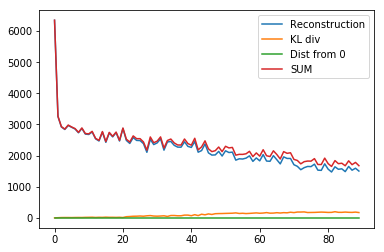

tensor(4., device='cuda:0') tensor(1., device='cuda:0') tensor(1., device='cuda:0')


In [933]:
import numpy as np

lossList = np.array(lossList)
plt.plot(lossList[:, 0], label="Reconstruction")
plt.plot(lossList[:, 1], label="KL div")
plt.plot(lossList[:, 2], label="Dist from 0")
plt.plot(lossList.sum(axis=1), label="SUM")
plt.legend()
lossList = list(lossList)
plt.show()
print(model.alpha.data, model.beta.data, model.gamma.data)

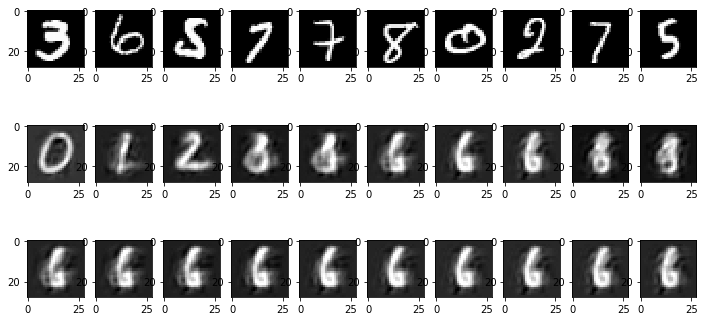

In [929]:
# make random z --> number

# z = torch.randn(1,model.dim_mu).cuda()
dim_z = [0.]*model.dim_mu
z=torch.Tensor([[*dim_z, i] for i in range(0,10)]).cuda()
# print(z)
output = model.decoder(z)
output = model.to_img(output).cpu()
output = torch.squeeze(output)

fig, axes = plt.subplots(3,10, figsize=(12,6))

# original data
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=10,
                                           shuffle=True)
data, target = iter(train_loader).next()
data = data.squeeze()
for i in range(0,10):
    axes[0][i].imshow(data[i], cmap='gray')

# VAE data
for j in range(0,10):
    axes[1][j].imshow(output[j].data, cmap='gray')

# condition vartiation data
k = np.linspace(5,7, 10)
z2=torch.Tensor([[*dim_z, i] for i in k]).cuda()
output = model.decoder(z2)
output = model.to_img(output).cpu()
output = torch.squeeze(output)

for idx, el in enumerate(k):
    axes[2][idx].imshow(output[idx].data, cmap='gray')

plt.show()


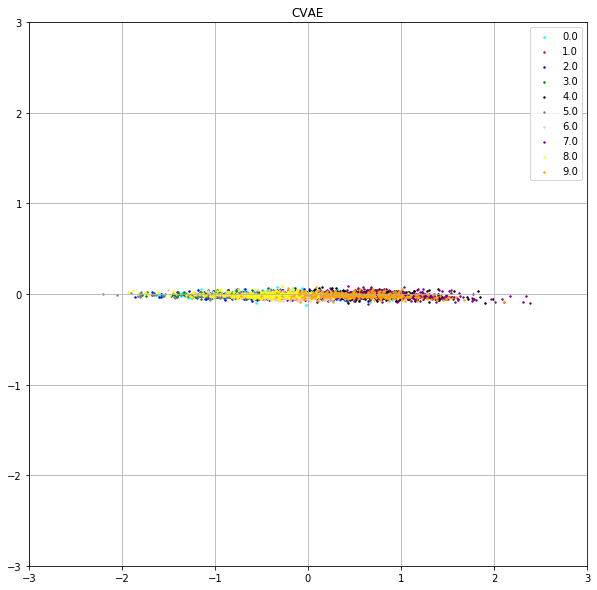

In [930]:
import numpy as np
from matplotlib import pyplot as plt

# show testset z disrtribution
model.eval()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4096,
                                           shuffle=True)

data, target = iter(train_loader).next()
data, target = data.to(device), target.to(device)
data = data.view(data.size(0), -1)
target = target.view(-1,1).float()
data_c = torch.cat((data, target), 1)

output = model.encoder(data)[:,[0,1]] # mu만 plot
# output = model.encoder(data_c)[:,:2] # mu만 plot
z_list = [output.cpu().data, data_c[:,-1].squeeze().cpu().data]
z_filter = [True]*z_list[1].shape[0] # 전부 생성
# z_filter = [True if i in [6, 9, 7] else False for i in z_list[1]] # 원하는 레이블만 생성

# plot
scatter_x = np.array(z_list[0][z_filter][:,0])
scatter_y = np.array(z_list[0][z_filter][:,1])
group = np.array(z_list[1][z_filter])
cdict = {0:'cyan', 1: 'red', 2: 'blue', 3: 'green', 4:'black', 5:'gray', 6:'pink', 7:'purple', 8:'yellow', 9:'orange'}

r = 3
fig, ax = plt.subplots(figsize=(10, 10))
plt.title('CVAE')
plt.xlim([-1*r, r])
plt.ylim([-1*r, r])
plt.grid()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 2)
ax.legend(loc=1)
plt.show()

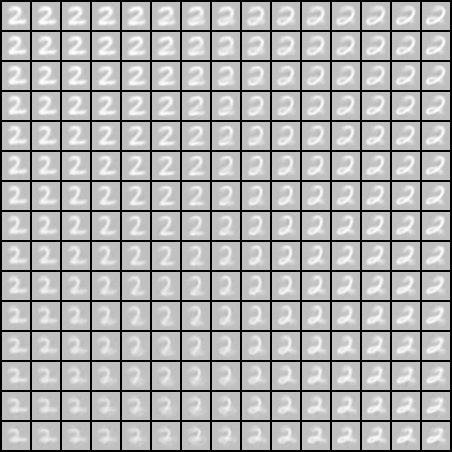

In [697]:
'''
매니폴드 표시
'''
from IPython.display import Image
from torchvision.transforms import ToPILImage

condition = 2
nrow = 15
r = 0.05

k = np.linspace(-1*r, r, nrow)
z_list = []
etc = [0]*(model.dim_mu-2)
for i in range(0,nrow):
    for j in range(0,nrow):
        z_list.append([k[i],k[j], *etc])
z_list = torch.Tensor(z_list)
c_list = torch.empty(()).new_full([nrow*nrow,1], condition)
z_c_list = torch.cat((z_list, c_list), dim=1)
# print(z_c_list.shape)

img_list = model.to_img(model.decoder(z_c_list.cuda()))
model.save_img(img_list, 'result.png', nrow=nrow, ncolumn=nrow)
Image(model.res_path+'/result.png')

## GAN

## AVAE

## ACVAE

In [13]:
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)


model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train_loader = torch.utils.data.DataLoader(dataset=512,
                                           batch_size=batch_size,
                                           shuffle=True)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        # sum up batch loss
#         print(output.shape, target.shape)
        test_loss += criterion(output, target).data
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297523
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.307143
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.300011
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.300258
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301978
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.300130
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.296896
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.298396
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.307897
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.309477
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300223
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.287798
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.294473
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.295319
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.305077
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.300325
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.305982
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.308043
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.288323
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.284431
Train Epoch: 1 [12800/60000 (

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([64, 10]) torch.Size([64])
torch.Size([

KeyboardInterrupt: 

In [48]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input, target)

tensor([[-1.0023, -0.2333,  0.8519, -0.8480, -0.1387],
        [ 0.2334, -1.1089,  1.3485, -1.2234,  0.9705],
        [-0.2005, -0.2133,  0.0656,  0.3765, -0.3108]], requires_grad=True) tensor([1, 1, 1])


In [54]:
>>> loss = nn.CrossEntropyLoss()
>>> input = torch.randn(3, 5, requires_grad=True)
>>> target = torch.empty(3, 5, dtype=torch.long)
# >>> target = torch.empty(3,dtype=torch.long).random_(5)
>>> output = loss(input, target)

RuntimeError: multi-target not supported at c:\a\w\1\s\windows\pytorch\aten\src\thnn\generic/ClassNLLCriterion.c:21